# 用各種不同方式寫同樣的神經網路

## 1. 初始準備

Keras 可以用各種不同的深度學習套件當底層, 我們在此指定用 Tensorflow 以確保執行的一致性。

In [1]:
%env KERAS_BACKEND = tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact,IntSlider

讀入建構神經網路用到的 Keras 相關函數

In [3]:
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD,Adam

from keras.datasets import mnist

from keras.utils import to_categorical

C:\Users\w8462\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 2. 讀入 MNIST 數據庫

MNIST 是有一堆 0-9 的手寫數字圖庫。有 6 萬筆訓練資料, 1 萬筆測試資料。它是 "Modified" 版的 NIST 數據庫, 原來的版本有更多資料。這個 Modified 的版本是由 LeCun, Cortes, 及 Burges 等人做的。可以參考這個數據庫的[原始網頁](http://yann.lecun.com/exdb/mnist/)。

MNIST 可以說是 Deep Learning 最有名的範例, 它被 Deep Learning 大師 Hinton 稱為「機器學習的果蠅」。

### 2.1 由 Keras 讀入 MNIST
標準手段

In [4]:
(x_train0,y_train0),(x_test0,y_test0)=mnist.load_data()

養成好習慣，沒事就看看資料的長相

In [5]:
print('共 %d 訓練資料，每筆資料尺寸為 %d X %d'%x_train0.shape)

共 60000 訓練資料，每筆資料尺寸為 28 X 28


### 2.3 輸入格式整理

我們現在要用標準神經網路學學手寫辨識。原來的每筆數據是個 28x28 的矩陣 (array), 但標準神經網路只吃「平平的」, 也就是每次要 28x28=784 長的向量。因此我們要用 `reshape` 調校一下。

In [6]:
x_train=x_train0.reshape((60000,28*28))
x_test=x_test0.reshape((10000,28*28))

將資料線性單位化至 $[0, 1]$。

In [7]:
x_train-=x_train.min()
x_train=x_train/x_train.max()

In [8]:
(x_train.min(),x_train.max())

(0.0, 1.0)

In [9]:
x_test-=x_test.min()
x_test=x_test/x_test.max()

我們來準備另一個 label，將 0~9 分成偶數(y=0)、奇數 (y=1)

In [10]:
y_train_num=to_categorical(y_train0,10)
y_test_num=to_categorical(y_test0,10)

In [11]:
y_train_eo=np.ones_like(y_train0)
y_train_eo[y_train0%2==0]=0

y_test_eo=np.ones_like(y_test0)
y_test_eo[y_test0%2==0]=0

沒事用互動模式畫個圖，十分酷炫 (?)

# 3. 回顧 Sequential

在第一周的時候，我們以下列的方式建立了一個具有下列設定

* 使用 <span style="color:red;">2</span> 個 hidden layers
* 每個 hidden layer 用 <span style="color:red;">500</span> 個神經用
* Activation Function 唯一指名 <span style="color:red;">sigmoid</span> (雖然好像有些同學測試出 <span style="color:red;"> ReLU </span> 比較好用...)
* 最後一層為類別層，有 **10** 個神經元，Activation Function 為 ``softmax``。

的神經網路，建立指令是透過建立 `Sequential()` 和 `.add` 的方式逐層建立，如下：

In [12]:
model =Sequential()

model.add(Dense(500,input_dim=28*28))
model.add(Activation('sigmoid'))
model.add(Dense(500))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               392500    
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_2 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5010      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 648,010
Trainable params: 648,010
Non-trainable params: 0
_________________________________________________________________


## 3.1 另一種使用 Sequential 建立神經網路的方式

觀察 ''model.layers``

In [13]:
model.layers

可以發現 `model` 就是一堆神經網路***層*** 堆疊起來。

``` Python
# 建立空的神經網路學習機
model = Sequential()

# 逐層建立神經網路 
model.add(Dense(500, input_dim=784)) # 將 `<keras.layers.core.Activation at 0xe558ef0>` 加進 model.layers
model.add(Activation('sigmoid'))     # 將 `<keras.layers.core.Dense at 0xe58a278>` 加入 model.layers
model.add(Dense(500))                # 將 `<keras.layers.core.Dense at 0xe58a278>` 加入 model.layers
model.add(Activation('sigmoid'))     # 將 `<keras.layers.core.Activation at 0xe558d68>` 加入 model.layers
model.add(Dense(10))                 # 將 `<keras.layers.core.Activation at 0xe558d68>` 加入 model.layers
model.add(Activation('softmax'))     # 將 `<keras.layers.core.Activation at 0xe58a898>` 加入 model.layers

model.summary()
```

換言之，神經網路其實就是將隱藏層逐層堆疊在一起的 list，因此，我們也可以 list 的形式來建立相同的神經網路。

首先，我們將兩個隱藏層及其 Activation Function 分別寫在 list 中，如下：

In [14]:
first_layer=[Dense(500,input_dim=28*28),Activation('sigmoid')]
second_layer=[Dense(500),Activation('sigmoid')]
final_layer=[Dense(10),Activation('softmax')]

從基本的 Python 資料結構中，我們知道 list 可以用 `+` 來進行合併，所以我們先來看看這三個 list 合併後的樣子。 

In [15]:
modle=Sequential(first_layer+second_layer+final_layer)

合併起來的 list 看起來就像是某個 `model.layers` 一樣，因此，我們只需將這些寫成 list 的隱藏層 `+` 起來送進 `Sequential` 中即可。

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               392500    
_________________________________________________________________
activation_1 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_2 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5010      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 648,010
Trainable params: 648,010
Non-trainable params: 0
_________________________________________________________________


### Q: 用 `.add` 和用 list 寫法建立的神經網路之差異？

### A: 沒有任何差別，前者可以很直覺得將神經網路堆疊起來，但後者則是轉移學習 (Transfer Learning) 的方式之一。

## 3.2 站在巨人的肩膀上 - 轉移學習

舉例來說，如果我們今天想進行的辨識資料從辨識數字 (0~9) 變成了辨識奇偶數 (0 or 1)，而且我們希望延用之前***除了最後一層***的模型。

顯然地，目前神經網路的 output 就與我們的需求不同，但我們想把前兩個隱藏層原封不動，只定義***新的最後一層***。

In [17]:
all_except_last_layer=[Dense(500,input_dim=28*28),
                       Activation('sigmoid'),
                       Dense(500),
                       Activation('sigmoid')]

last_layer=[Dense(10),Activation('softmax')]

model_num=Sequential(all_except_last_layer+last_layer)

model_num.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 500)               392500    
_________________________________________________________________
activation_7 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_8 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5010      
_________________________________________________________________
activation_9 (Activation)    (None, 10)                0         
Total params: 648,010
Trainable params: 648,010
Non-trainable params: 0
_________________________________________________________________


讀取個權重，記得要先 ``compile``，才能 ``fit``, ``evaluate``, ``predict``, ``predict_classes``

舉例來說，如果我們今天想進行的辨識資料從辨識數字 (0~9) 變成了辨識奇偶數 (0 or 1)，而且我們希望延用之前***除了最後一層***的模型。

顯然地，目前神經網路的 output 就與我們的需求不同，但我們想把前兩個隱藏層原封不動，只定義***新的最後一層***。

In [18]:
model_num.load_weights('handwriting_model_weights.h5')

In [19]:
model_num.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['acc'])

In [20]:
score=model_num.evaluate(x_train,y_train_num,batch_size=10000)

60000/60000 [==============================] - 1s 11us/step


In [21]:
print(score)

[0.4705149233341217, 0.8622666597366333]


但這個網路並不是重點，我們只希望***借用***某些部分。

我們希望**借用**這個模型的某些部分。來建立 **奇、偶數辨識模型**，模型設定如下：

* 使用 <span style="color:red;">2</span> 個 hidden layers
* 每個 hidden layer 用 <span style="color:red;">500</span> 個神經元
* Activation Function 唯一指名 <span style="color:red;">sigmoid</span> (雖然好像有些同學測試出 <span style="color:red;"> ReLU </span> 比較好用...)
* 最後一層為類別層，有 ~~10~~ **<span style="color:red;">2</span>** 個神經元，Activation Function 為 ``softmax``。

In [22]:
last_layer_eo=[Dense(2),Activation('softmax')]

In [23]:
model_eo=Sequential(all_except_last_layer+last_layer_eo)
model_eo.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 500)               392500    
_________________________________________________________________
activation_7 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_8 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 1002      
_________________________________________________________________
activation_10 (Activation)   (None, 2)                 0         
Total params: 644,002
Trainable params: 644,002
Non-trainable params: 0
_________________________________________________________________


什麼都不做，就直接 ``evaluate``

In [24]:
model_eo.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['acc'])

In [25]:
y_train_eo=to_categorical(y_train_eo,2)

In [26]:
score=model_eo.evaluate(x_train,y_train_eo,batch_size=10000)

60000/60000 [==============================] - 1s 9us/step


In [27]:
print(score)

[0.8133865892887115, 0.4915333290894826]


訓練過後再看一次：

In [28]:
model_eo.fit(x_train,y_train_eo)

Epoch 1/1
60000/60000 [==============================] - 6s 105us/step - loss: 0.3699 - acc: 0.8456


我們再回頭看看原本模型發生什麼事情

In [29]:
model_num.evaluate(x_train,y_train_num)

60000/60000 [==============================] - 2s 33us/step


[0.46726733455260594, 0.8658166666666667]

如果希望借來的模型權重，在訓練過程中不要改變，該如何做？

In [30]:
all_except_last_layer[0].trainable==False

False

In [31]:
for layer in all_except_last_layer:
    layer.trainable=False

In [32]:
all_except_last_layer[3].trainable

False

In [33]:
model_eo.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['acc'])
model_eo.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 500)               392500    
_________________________________________________________________
activation_7 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               250500    
_________________________________________________________________
activation_8 (Activation)    (None, 500)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 1002      
_________________________________________________________________
activation_10 (Activation)   (None, 2)                 0         
Total params: 644,002
Trainable params: 1,002
Non-trainable params: 643,000
_________________________________________________________________


1. 重新讀取**舊**模型權重 (並 evaluate)
2. 定義新模型並凍結**舊**模型的部分
3. 訓練新模型
4. 回頭看就模型的evaluate

In [34]:
model_num.load_weights('handwriting_model_weights.h5')

In [35]:
model_eo=Sequential(all_except_last_layer+last_layer_eo)
model_eo.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['acc'])

In [36]:
model_eo.fit(x_train,y_train_eo)

Epoch 1/1
60000/60000 [==============================] - 5s 76us/step - loss: 0.3472 - acc: 0.8499


In [37]:
model_num.evaluate(x_train,y_train_num,batch_size=10000)

60000/60000 [==============================] - 0s 7us/step


[0.4705149233341217, 0.8622666597366333]

# 恭喜！現在的你/妳已經學會實作轉移學習了！

雖然這個模型看起來很隨便，但轉移學習的模型**差不多**都是這樣建立的，實際上， Keras 亦提供許多被證實有良好表現且訓練好 (pre-trained) 的模型，如:

* Xception
* VGG16
* VGG19
* ResNet50
* InceptionV3
* InceptionResNetV2
* MobileNet
* DenseNet
* NASNet

詳細的使用方式可參考 Keras Documentation: https://keras.io/applications/

但使用這些模型進行轉移學習，**可能**需要 ``Sequential`` 以外寫法，以及更多神經網路的建構技巧。

# 4. 寫起來像寫數學函數的 Functional API

在此之前，我們使用 Sequential 便足以建構大多數的神經網路，那是因為我們接觸的神經網路多為線性堆疊 (linear stack)。

除了輸入層需指定 `input_dim` 外，其餘隱藏層只需宣告，那是因為 Sequential 會認定上一層的輸出這一層的輸入。

因此，再建構線性堆疊的神經網路時，Sequential 便足以處理。

### 4.1 Functional API 的使用時機

當神經網路模型為非線性的複雜網路結構，如：

* 多重輸出-多重輸入模型 (Multi-input and multi-output models)
  + 分歧 (branch)
  + 合併 (merge)
* 具重複/循環結構的模型，如: CycleGAN

Sequential 便不足以建構這類複雜結構的神經網路，我們以下介紹 `Model` Fnuctional API 的使用。

在 `Model` 的世界中，所有的神經網路層 (全連接, 卷積, 池化, RNN等) 都將視作函數來定義，因此，我們只需關心函數的輸入和輸出即可。

此外，為了讓神經網路的第一層從不需要輸入 `input_dim`，我們還需引進下面這個函數來代替 `input_dim`。 (此寫法亦可用在 `Sequential`)

In [38]:
from keras.models import Model
from keras.layers import Input

### 4.2 Functional API 的函數概念

回顧一下，我們想學習的手寫辨識模型是一個長得像這樣的函數

$$\hat{f} \colon \mathbb{R}^{784} \to \mathbb{R}^{10}$$

我們希望建立一個具有兩個隱藏層的神經網路來學習這個函數，攤開來看的話，如下：

$$\mathbb{R}^{784} \overset{f_1}{\to} \mathbb{R}^{500} \overset{f_2}{\to} \mathbb{R}^{500} \overset{f_3}{\to} \mathbb{R}^{10}$$

$$x \overset{f_1}{\mapsto} h_1 \overset{f_2}{\mapsto} h_2 \overset{f_3}{\mapsto} y$$


或是以簡易的圖來表示這個全連接神經網路

<img src="plain_model.png" alt="drawing" style="width: 400px;"/>

其中，$f_1, f_2, f_3$ 代表的是全連結層所代表的函數，其他變數說明如下：

* $x$: 代表的是輸入模型的圖片向量，為 784 維的向量。
* $h_1$: $x$ 經過第一層隱藏層運算後得結果，即為 $f_1(x)$，為 500 維的向量。
* $h_2$: $h_1$ 經過第二層隱藏層運算後得結果，即為 $f_2(h_1)$，為 500 維的向量。
* $y$: $h_2$ 經過最後一層運算後得結果，即為 $f_3(h_2)$，為 10 維的向量，代表的是 $x$ 為哪個數字的機率。

注意: 為了方便，我們將 `Dense(500)`, `Activation('sigmoid')` 兩個合併用 `Dense(500, activation='sigmoid')` 表示

### 4.3 Functional API 的操作方式

我們沿用上圖的變數名稱來定義

In [39]:
x=Input(shape=(784,))

In [40]:
f_1=Dense(500,activation='sigmoid')
f_2=Dense(500,activation='sigmoid')
f_3=Dense(10,activation='softmax')

接著，定義層前後變數之間的關係；首先，第一個變數必定以 `Input` 函數來定義

In [41]:
h_1=f_1(x)

In [42]:
print(x)

Tensor("input_1:0", shape=(?, 784), dtype=float32)


In [43]:
print(h_1)

Tensor("dense_11/Sigmoid:0", shape=(?, 500), dtype=float32)


In [44]:
print(f_1)

剩下的部分，就如變數說明，**幾乎**可以照著數學式輸入 $$h_1 = f_1(x), h_2 = f_2(h_1), y = f_3(h_2)$$

In [45]:
h_2=f_2(h_1)
y=f_3(h_2)

在這裡，變數 $h_1, h_2, y$ 是以張量 (tensor) 類別來表示，我們可以嘗試 `print` 看看。

接著，透過 `Model` 將一個模型的輸入/輸出包裝起來，建立模型的過程就完成了！

In [46]:
model=Model(x,y)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 500)               392500    
_________________________________________________________________
dense_12 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_13 (Dense)             (None, 10)                5010      
Total params: 648,010
Trainable params: 648,010
Non-trainable params: 0
_________________________________________________________________


一樣的，當模型 compile 之後，便可以進行資料的訓練、預測等等，請有興趣的同學讀入 MNIST 手寫辨識之料後，自行完成這個模型的訓練。

In [47]:
model.compile(loss='mse', optimizer=SGD(lr=0.1), metrics=['accuracy'])

In [48]:
# model.fit(x_train, y_train, batch_size=100, epochs=5)

雖然 summary 少了很多東西，但模型架構和之前做的沒有差異，所以可以安心讀入之前訓練好的權重。

In [49]:
model.load_weights('handwriting_model_weights.h5')

In [51]:
score = model.evaluate(x_train, y_train_num, batch_size=10000)
print("Loss: %f" %score[0])
print("準確率: %f" %(score[1]*100))

60000/60000 [==============================] - 1s 11us/step
Loss: 0.021306
準確率: 86.226666


### 4.4 小結論
Functional API 的操作流程如下：
1. 將層定義成明確的函數
2. 透過層函數將變數連接
3. 定義神經網路的輸入與輸出

## 5. 非線性堆疊模型

### 5.1 如果建立具分歧及合併結構的神經網路模型呢？

In [52]:
from keras.layers import concatenate,add

首先，假設我們希望在模型之間增加一個分歧，且這個分歧在模型的輸出會合併，則神經網路的結構會變成：

<img src="branch-and-merge.png" alt="drawing" style="width: 400px;"/>

此模型為單一輸入、多重輸出的模型，是分歧模型最容易處理的一種。

其中，$f_1, f_2$ 同之前，$f_4:\mathbb{R}^{500}\to\mathbb{R}^{500}$ 的全連接層，但 `Activation` 改用 `ReLu`。

需注意的是，由於 $f_3$ 的定義域改變，為 $\mathbb{R}^{500}\times\mathbb{R}^{500}\to\mathbb{R}^{10}$ 函數，所以需要重新定義。

* $x$: 代表的是輸入模型的圖片向量，為 784 維的向量。
* $h_1$: $x$ 經過 $f_1$ 隱藏層運算後得結果，即為 $f_1(x)$，為 500 維的向量。
* $h_2$: $h_1$ 經過 $f_2$ 隱藏層運算後得結果，即為 $f_2(h_1)$，為 500 維的向量。

* $z$: $h_1$ 經過 $f_4$ 運算後得結果，即為 $f_4(h_1)$，為 500 維的向量。
* $y$: $h_2$ 和 $z$ 經過新的 $f_3$ 運算後得結果，即為 $f_3(h_1, z)$，為 10 維的向量，代表的是 $x$ 為哪個數字的機率。

因為上面已將 $f_4$ 及 $z$ 以外的變數定義好，我們只需定義 $f_3$, $f_4$ 及 $z$ 即可

In [54]:
f_3=Dense(10,activation='softmax')
f_4=Dense(500,activation='relu')

z=f_4(h_1)

接著，再將 $y = f_3(h_2, z)$ 定義好，就會發現......

In [55]:
# 此段程式碼為錯誤範例
y=f_3(h_2,z)

TypeError: __call__() takes 2 positional arguments but 3 were given

聰明的你/妳，可能會想到，函數的寫法是一次送進一個變數，那我們將 $h_3$ 和 $z$ 寫成 `list` 的形式，應該就可以送進去 $f_3$ 了吧？

In [58]:
# 此段程式碼為錯誤範例
y=f_3([h_2,z])

ValueError: Layer dense_16 expects 1 inputs, but it received 2 input tensors. Input received: [<tf.Tensor 'dense_12/Sigmoid:0' shape=(?, 500) dtype=float32>, <tf.Tensor 'dense_17/Relu:0' shape=(?, 500) dtype=float32>]

會發現這樣也沒辦法成功。其實正確的作法是，先將 $h_2$ 與 $z$ 透過 `concatenate` 接在一起，再送進新的 $f_3$ 裡。

在這裡，我們將 $h_2$ 與 $z$ `concatenate` 接在一起，稱做 $u$。

In [57]:
u=concatenate([h_2,z])

In [59]:
y=f_3(u)

換句話說，模型其實是這樣畫的

<img src="branch-and-merge_final.png" alt="drawing" style="width: 400px;"/>

其中，`concatenate` 是將不同的變數**接**在一起，這裡面並沒有進行任何涉及權重的運算。

再透過 `Model` 將模型的輸入和輸出包裝起來，即可將模型建構完成。

In [60]:
model=Model(x,y)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 500)          392500      input_1[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 500)          250500      dense_11[0][0]                   
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 500)          250500      dense_11[0][0]                   
__________________________________________________________________________________________________
concatenat

### 5.2 小結論
Branch-and-Merge 的注意要點如下：
1. 每一層分別定義成函數
2. 分歧結構: 實就是透過新的函數來定義新的變數，無特別注意事項。
3. 合併結構: 要合併前，將所有要進入的變數都合併起來，才能進行之後的運算。

常見應用:
1. 多重輸入-多重輸出模型。
2. 當層函數為 convolution 時，這樣的技巧可以實現 U-net 上的重要結構 multi-resolution fusion (多解析度融合，又稱 MRF)。
3. ResNet 上的重要結構 skip connection (跳躍式傳遞)，亦可透過分歧-合併來實現，只是 ResNet 使用的是 `add` 而非 `concatenate`。

### 5.3 自定義的不具可訓練權重之神經網路層
這裡，我們將進行這單元最後一個重要的神經網路建構技巧 - 自定義神經網路層 (不具可訓練權重)

** 具有可訓練重的自定義層牽扯到 TensorFlow 及 Python 類別的撰寫，若有興趣可參考: https://keras.io/layers/writing-your-own-keras-layers/

首先，我們需要引入 `Lambda` 這個函數，透過 `Lambda` 函數，我們可以將 Python 上的 function，包裝成 Keras 上的 layer。

此外，我們需要引進後端所使用的套件 (此處為 TensorFlow)，並使用裡面的運算進行 function 的撰寫。

In [61]:
from keras.layers import Lambda

首先，我們透過 backend 來定義一個簡單的 function，作用是對輸入取平均，程式碼如下：

In [62]:
from keras import backend as K

接著，我們將一個 numpy array 送進這個函式，看看會發生什麼事。

In [64]:
# 此段程式碼為錯誤範例
test_array=np.arange(12).reshape(1,2,6)
K.mean(test_array)

AttributeError: 'numpy.dtype' object has no attribute 'base_dtype'

你/妳會發現，這邊的函式不接受 numpy array 的類型作為輸入，這是因為 TensorFlow 有自定義的類型，因此，在這邊我們沒辦法直接使用這個函式。

In [70]:
y=K.mean(x)
model=Model(x,y)

ValueError: Output tensors to a Model must be the output of a Keras `Layer` (thus holding past layer metadata). Found: Tensor("Mean_2:0", shape=(), dtype=float32)

我們透過 `Lambda` ，將上述函式包裝成一個神經網路層。

In [84]:
keras_mean=Lambda(K.mean,output_shape=(5,))

In [85]:
keras_mean(x)

<tf.Tensor 'lambda_4/Mean:0' shape=() dtype=float32>

In [86]:
model=Model(x,keras_mean(x))

In [87]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 5)                 0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


此時，下述程式碼可以建構出一個將指定長度的資料取平均的神經網路。

In [88]:
model.predict(x_train[0:1])

array([0.13768007], dtype=float32)

In [89]:
x_train[0:1].mean()

0.13768007202881152

可以發現，這樣的神經網路是不具有訓練權重的。

記得，在使用前記得先 compile

接著，我們將 `[1, 2, 3, 4]` 送進這個神經網路，看看神經網路的輸出是否為這個向量的**平均。

可以發現，將 `[1, 2, 3, 4]` 轉成 Numpy array 送進神經網路**預測**後，答案是 `2.5`，即為 (1+2+3+4)/4，確實是平均。

我們也可以一次送進多筆資料進行平均的計算。

### 加碼: 具抽樣功能的神經網路層

輸入為 $(\mu, s)$ ，$\mu=(\mu_1,\cdots,\mu_n)$ 和 $s=(s_1,\cdots,s_n)$ 各自為 $n$ 維向量。

我們希望神經網路層輸出為服從 $N(\mu, e^{s}I_n)$ 的 $n$ 維向量，換言之，我們希望建構的神經網路其實是一個抽樣函數。

** 由於神經網路的輸入輸出經常沒有限制，為了讓 $s$ 具有變異數的非負特性，我們考慮 $e^{s}$ 作為變異數；換言之，$s$ 為 log-variance。

假設我們想進行抽樣的維度為 `sampling_dim`，則一個具抽樣函數功能的神經網路可由下述方式建構。

In [90]:
sampling_dim=2

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(sampling_dim,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

這裡使用到常態分配的線性特性來定義函數，亦即

$$X\sim N(0, 1)\Rightarrow \mu+\sigma X\sim N(\mu, \sigma^2)$$


若不熟機率論的同學，可以詢問助教。

In [91]:
sample_layer=Lambda(sampling,output_shape=(sampling_dim,))

In [94]:
m=Input(shape=(sampling_dim,))
log_s=Input(shape=(sampling_dim,))

In [98]:
y=sample_layer([m,log_s])

In [99]:
sampling_model=Model(input=[m,log_s],output=y)

C:\Users\w8462\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`
  """Entry point for launching an IPython kernel.


In [100]:
sampling_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 2)            0           input_2[0][0]                    
                                                                 input_3[0][0]                    
Total params: 0
Trainable params: 0
Non-trainable params: 0
__________________________________________________________________________________________________


透過下面的指令，我們每次可以抽樣出一服從上述要求常態分配之隨機向量

In [101]:
sampling_model.predict([[[4.,2.]],[[0.,0.]]])

array([[2.8339381, 1.2206626]], dtype=float32)

來和 Numpy 上的抽樣函數進行比較吧~

In [111]:
np_sampling=np.random.multivariate_normal([4.,2.],np.identity(2),size=100)

In [109]:
keras_sampling = np.zeros((100,2))

for i in range(100):
    keras_sampling[i] = sampling_model.predict([[[4.,2.]],[[0.,0.]]])

In [110]:
keras_sampling

array([[ 4.68292856,  2.54613066],
       [ 4.98414373,  1.73676264],
       [ 2.23056698,  3.08676887],
       [ 3.15441179,  3.12844849],
       [ 4.96794033,  3.04521656],
       [ 2.99856687,  1.34839678],
       [ 2.95140409,  3.52775645],
       [ 5.14469719,  1.30051696],
       [ 5.91270781,  0.93190944],
       [ 2.65565062,  2.7125144 ],
       [ 3.98483348,  2.85906458],
       [ 4.44659662,  1.77331531],
       [ 6.03554916,  1.47289681],
       [ 3.31435299,  0.58975995],
       [ 2.96936226,  2.79464483],
       [ 3.27915955,  3.08230495],
       [ 4.65768003,  2.11808658],
       [ 5.69616461,  3.82648468],
       [ 3.99084783,  2.09306812],
       [ 4.04108953,  1.20826101],
       [ 5.48215151,  3.03447676],
       [ 3.11104989,  2.37038398],
       [ 5.07081127,  1.67368269],
       [ 3.52594209,  2.78188848],
       [ 4.67748928,  1.64330208],
       [ 3.55640864,  2.44947147],
       [ 3.1495924 ,  3.60712242],
       [ 3.62737632,  1.07746887],
       [ 3.72369003,

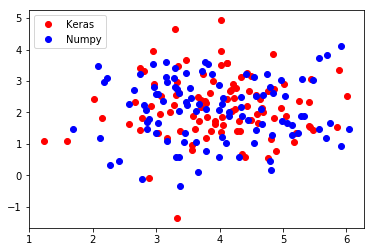

In [114]:
plt.plot(np_sampling[:,0],np_sampling[:,1],'ro')
plt.plot(keras_sampling[:,0],keras_sampling[:,1],'bo')
plt.legend(['Keras', 'Numpy'])

## 恭喜你，完成所有建立 Variational Autoencoder 所需的重要技巧。

Variational Autoencoder (VAE) 是一個重要的非監督式學習模型，具體應用的場合為特徵抽取/資料壓縮及還原，為影像處理中常見的模型之一。

在建立 VAE中，需要三個重要技巧:
* 分歧-合併
* 自定義函數 (抽樣函數)
* 自定義損失函數

雖然不知道之後課程會不會用到，但多學點總是好的 : )